[View in Colaboratory](https://colab.research.google.com/github/snastase/ISC-tutorial/blob/master/ISC_Tutorial.ipynb)

<h1>Intersubject correlation (ISC) tutorial</h1>
This tutorial jupyter notebook accompanies the manuscript "Measuring shared responses across subjects using intersubject correlation" by Keysers, Gazzola, Nastase, and Hasson. The goal of the tutorial is to introduce basic intersubject correlation (ISC) analyses and subsequent statistical tests as implemented in Python using the Brain Imaging Analysis Kit ([BrainIAK](http://brainiak.org/)).

---

Author: Sam Nastase

## Getting started
First, we'll need to [install BrainIAK](http://brainiak.org/docs/installation.html) and its requirements—this may take a few minutes.

In [0]:
!apt install build-essential libgomp1 libmpich-dev mpich python3-dev \
             python3-pip python3-venv
!pip install brainiak

Next, we'll load several useful Python modules.

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.multitest import multipletests

For now, if unable to install BrainIAK, we can load basic ISC functionality.

In [50]:
from google.colab import files
files.upload()
from isc_demo import (isc, bootstrap_isc, permutation_isc,
                      timeshift_isc, phaseshift_isc)

Saving isc_demo.py to isc_demo (1).py


## Example data
We'll create a simple simulated dataset for quickly applying ISC analyses, then apply the analyses to a real fMRI dataset where participants listened to a spoken narrative ([Pie Man](https://themoth.org/stories/pie-man) by Jim O'Grady). Our simulated data will have 1,000 voxels in total comprising 10 "networks" and 300 time points (or TRs).

In [0]:
# Set parameters for toy time series data
n_subjects = 20
n_TRs = 300
n_voxels = 1000

# Create simple simulated data with high intersubject correlation
def simulated_timeseries(n_subjects, n_TRs, n_voxels=1, noise=1):
  signal = np.random.randn(n_TRs, n_voxels // 100)
  data = [np.repeat(signal, 100, axis=1) +
          np.random.randn(n_TRs, n_voxels) * noise
          for subject in np.arange(n_subjects)]
  return data

# List of subject datasets
data = simulated_timeseries(n_subjects, n_TRs, n_voxels=n_voxels)

Simulated data shape first subject: (300, 1000) 
i.e., 300 time points and 1000 voxels


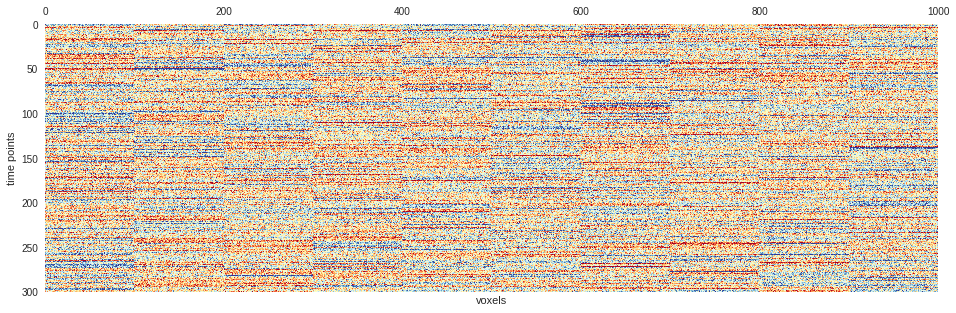

In [52]:
# Inspect the shape of one of our simulated datasets
print(f"Simulated data shape first subject: {data[0].shape} "
      f"\ni.e., {data[0].shape[0]} time points and {data[0].shape[1]} voxels")

# Create a simple visualization of the data
plt.matshow(data[0], cmap='RdYlBu', vmin=-3, vmax=3)
plt.grid(False)
plt.xlabel('voxels')
plt.ylabel('time points');

## ISC analysis
Let's start very simple by computing the ISC for a single voxel (or ROI) across only two participants. This should give us a simple Pearson correlation value (and should match other implementations of Pearson correlation). Note that when you call the isc() function with verbose=True (the default), it outputs some warnings describing what it infers about the input data. If these don't match your assumptions, your input data may be organized improperly.

In [53]:
# Get the time series for a single voxel in two subjects
subject_a = data[0][:, 0]
subject_b = data[1][:, 0]

# Check the shape of these mini-datasets
print(f"Subject A, first voxel, shape = {subject_a.shape} "
      f"\nSubject B, first voxel, shape = {subject_b.shape}")

# Combine these into a list
both_subjects = [subject_a, subject_b]

# Compute the ISC for this voxel across the two subjects
iscs = isc(both_subjects, pairwise=True, verbose=True)
print(f"ISC for first voxel across subjects A and B = {iscs[0][0]}")

# NB: even for a single voxel, the output ISC is shaped to 
# to accommodate an n_ISCs x n_voxels matrix
print(f"ISC output shape = {iscs.shape}"
      f"\ni.e., {iscs.shape[0]} ISC value(s) by {iscs.shape[0]} voxel(s)")

# Check that ISC output matches of other correlation functions in python
numpy_corrcoef = np.corrcoef(subject_a, subject_b)[0, 1]

from scipy.stats import pearsonr
scipy_pearsonr = pearsonr(subject_a, subject_b)[0]

print(f"BrainIAK ISC = {iscs[0][0]}"
      f"\nNumpy's correlation = {numpy_corrcoef}"
      f"\nScipy's correlation = {scipy_pearsonr}")
assert np.isclose(iscs, numpy_corrcoef) and np.isclose(iscs, scipy_pearsonr)

Subject A, first voxel, shape = (300,) 
Subject B, first voxel, shape = (300,)
Assuming 2 subjects with 300 time points and 1 voxel(s) or ROI(s).
Only two subjects! Simply computing Pearson correlation.
ISC for first voxel across subjects A and B = 0.5518464375462817
ISC output shape = (1, 1)
i.e., 1 ISC value(s) by 1 voxel(s)
BrainIAK ISC = 0.5518464375462817
Numpy's correlation = 0.5518464375462816
Scipy's correlation = 0.5518464375462817


### Pairwise approach
Now we'll run the full-scale ISC analysis across all voxels and subjects using the pairwise approach. For a given voxel, the correlations between each pair of subjects are represented in a vector of length
```
n_subjects * (n_subjects - 1) / 2
```
or 190 pairs for 20 subjects. This vector of pairs corresponds to the off-diagonal values of a symmetric subjects-by-subjects correlation matrix.



In [63]:
# Pairwise approach across all subjects and voxels
iscs = isc(data, pairwise=True)

# Check shape of output ISC values
print(f"ISC values shape = {iscs.shape} \ni.e., {iscs.shape[0]} "
      f"pairs and {iscs.shape[1]} voxels"
      f"\nMinimum ISC = {np.amin(iscs)}; maximum ISC = {np.amax(iscs)}")

Assuming 20 subjects with 300 time points and 1000 voxel(s) or ROI(s).
ISC values shape = (190, 1000) 
i.e., 190 pairs and 1000 voxels
Minimum ISC = 0.2930333374119572; maximum ISC = 0.661264369657027


For a given voxel, we can convert the vector of pairs to the full correlation matrix for visualization. In the simulated dataset, all subjects were designed to have high ISCs; however, we can add noise to some of the subjects and then visualize the ISC matrix.

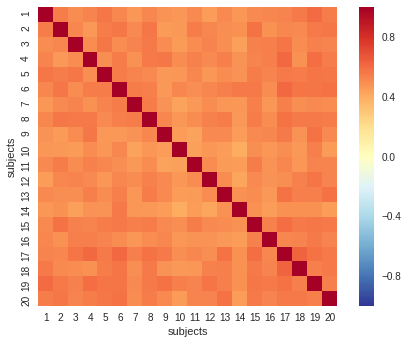

Assuming 20 subjects with 300 time points and 1000 voxel(s) or ROI(s).


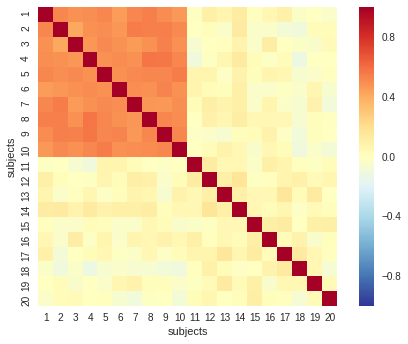

In [57]:
# Visualize the correlation matrix for one voxel
from scipy.spatial.distance import squareform

isc_matrix = squareform(iscs[:, 0])
np.fill_diagonal(isc_matrix, 1)
sns.heatmap(isc_matrix, cmap="RdYlBu_r", vmin=-1, vmax=1, square=True, 
            xticklabels=range(1, 21), yticklabels=range(1, 21))
plt.xlabel('subjects')
plt.ylabel('subjects')
plt.show()

# Create noisier data
noisy_data = np.dstack((np.dstack((
    simulated_timeseries(n_subjects // 2, n_TRs,
                         n_voxels=n_voxels, noise=1))),
                        np.dstack((
    simulated_timeseries(n_subjects // 2, n_TRs,
                         n_voxels=n_voxels, noise=5)))))

# Recompute ISC and visualize data with noisy subjects
noisy_iscs = isc(noisy_data, pairwise=True)
isc_matrix = squareform(noisy_iscs[:, 0])
np.fill_diagonal(isc_matrix, 1)
sns.heatmap(isc_matrix, cmap="RdYlBu_r", vmin=-1, vmax=1, square=True, 
            xticklabels=range(1, 21), yticklabels=range(1, 21))
plt.xlabel('subjects')
plt.ylabel('subjects')
plt.show()

### Leave-one-out approach
Instead of computing ISCs between each pair of subjects, for each subject we can compute the ISC between that subject and the average of all other subjects. Notice that the observed ISC values are typically higher in the leave-one-out approach due to computing correlations between the left-out subject and the cleaner averaged time series from the remaining subjects.

In [65]:
# Leave-one-out approach
iscs = isc(data, pairwise=False)

# Check shape of output ISC values
print(f"ISC values shape = {iscs.shape} \ni.e., {iscs.shape[0]} "
      f"left-out subjects and {iscs.shape[1]} voxel(s)"
      f"\nMinimum ISC = {np.amin(iscs)}; maximum ISC = {np.amax(iscs)}")

Assuming 20 subjects with 300 time points and 1000 voxel(s) or ROI(s).
ISC values shape = (20, 1000) 
i.e., 20 left-out subjects and 1000 voxel(s)
Minimum ISC = 0.5503274135636584; maximum ISC = 0.787229783035751


### Input types
Currently, we're a submitting a list of numpy arrays to BrainIAK's ISC function where each item in the list is a subject's response time course over some number of voxels. Alternatively, we could stack subjects along the 3rd dimension into a single 3-dimensional numpy array and submit this to the ISC function. If the ISC function receives a single numpy array, it will assume that the last dimension indexes subjects.

In [70]:
# Input a list of subjects (same as before)
iscs = isc(data, pairwise=False)

# Stack subjects in 3rd-dimension and recompute ISC
data_stack = np.dstack(data)
print(f"Stacked data shape = {data_stack.shape}"
      f"\ni.e., {data_stack.shape[0]} time points, {data_stack.shape[1]} "
      f"voxels, and {data_stack.shape[2]} subjects")

# Input stacked numpy array
iscs_from_stack = isc(data, pairwise=False)

# Make sure the ISC outputs are the same
assert np.array_equal(iscs, iscs_from_stack)

Assuming 20 subjects with 300 time points and 1000 voxel(s) or ROI(s).
Stacked data shape = (300, 1000, 20)
i.e., 300 time points, 1000 voxels, and 20 subjects
Assuming 20 subjects with 300 time points and 1000 voxel(s) or ROI(s).


### Summary statistics
Rather than returning ISC values for each pair of subject (in the pairwise approach) or each left-out subject (in the leave-one-out approach), we can use the summary_statistic argument to output either the mean or median across the values. Note that by default summary_statistic=False. If we request the mean ISC value, the ISC function will internally apply the Fisher *z*-transformation prior to computing the mean, then apply the inverse Fisher *z*-transformation to the mean value.

In [74]:
# Compute mean leave-one-out ISC
iscs = isc(data, pairwise=False, summary_statistic=np.mean)

print(f"ISC values shape = {iscs.shape} \ni.e., {iscs.shape[0]} "
      f"mean value across left-out subjects and {iscs.shape[1]} voxel(s)")

# Compute median leave-one-out ISC
iscs = isc(data, pairwise=False, summary_statistic=np.median)

print(f"ISC values shape = {iscs.shape} \ni.e., {iscs.shape[0]} "
      f"median value across left-out subjects and {iscs.shape[1]} voxel(s)")

Assuming 20 subjects with 300 time points and 1000 voxel(s) or ROI(s).
ISC values shape = (1, 1000) 
i.e., 1 mean value across left-out subjects and 1000 voxel(s)
Assuming 20 subjects with 300 time points and 1000 voxel(s) or ROI(s).
ISC values shape = (1, 1000) 
i.e., 1 median value across left-out subjects and 1000 voxel(s)


## Statistical tests
Statistical tests return the actual observed ISC values, p-values, and optionally the resampling distribution. The bootstrap hypothesis test also returns confidence intervals around the observed ISC statistic.

In [0]:
# Phase randomization
observed, p, distribution = phaseshift_isc(data, pairwise=False,
                                           return_distribution=True)

# Circular time-shift
observed, p, distribution = timeshift_isc(data, pairwise=False,
                                          return_distribution=True)

# Bootstrap test
observed, ci, p, distribution = bootstrap_isc(data, pairwise=False, ci=95,
                                              return_distribution=True)

# Permutation test
observed, p, distribution = permutation_isc(data, pairwise=False,
                                            return_distribution=True)

## Multiple comparisons correction
Controlling the false discovery rate (FDR), and maximum statistic across voxels for permutation approach.

In [0]:
# Control FDR using statsmodels
q = multipletests(combined_p[0, :], method='fdr_by')[1]
z = np.abs(norm.ppf(fdr))

# Write function to aggregate max stat across voxels from null distribution

## ISFC analysis
Compute ISFC

In [0]:
# Compute ISFCs
isfcs = isfc(data, pairwise=False)

# Demonstrate that diagonal of ISFC matrix matches ISCs
isc = isc(data, pairwise=False)

## References and suggested reading

Chen, G., Shin, Y. W., Taylor, P. A., Glen, D. R., Reynolds, R. C., Israel, R. B., & Cox, R. W. (2016). Untangling the relatedness among correlations, part I: nonparametric approaches to inter-subject correlation analysis at the group level. *NeuroImage*, *142*, 248–259. https://doi.org/10.1016/j.neuroimage.2016.05.023

Chen, G., Taylor, P. A., Shin, Y. W., Reynolds, R. C., & Cox, R. W. (2017). Untangling the relatedness among correlations, part II: inter-subject correlation group analysis through linear mixed-effects modeling. *NeuroImage*, *147*, 825–840. https://doi.org/10.1016/j.neuroimage.2016.08.029

Hasson, U., Malach, R., & Heeger, D. J. (2010). Reliability of cortical activity during natural stimulation. *Trends in Cognitive Sciences*, *14*(1), 40–48. https://doi.org/10.1016/j.tics.2009.10.011

Hasson, U., Nir, Y., Levy, I., Fuhrmann, G., & Malach, R. (2004). Intersubject synchronization of cortical activity during natural vision. *Science*, *303*(5664), 1634–1640. https://doi.org/10.1126/science.1089506

Kauppi, J. P., Pajula, J., & Tohka, J. (2014). A versatile software package for inter-subject correlation based analyses of fMRI. *Frontiers in Neuroinformatics*, *8*, 2. https://doi.org/10.3389/fninf.2014.00002

Simony, E., Honey, C. J., Chen, J., Lositsky, O., Yeshurun, Y., Wiesel, A., & Hasson, U. (2016). Dynamic reconfiguration of the default mode network during narrative comprehension. *Nature Communications*, *7*, 12141. https://doi.org/10.1038/ncomms12141